In [1]:
import pandas as pd
import numpy as np

import sklearn.metrics
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import time

import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


from sklearn.metrics import root_mean_squared_error, make_scorer


#from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from IPython.display import display

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes.

 Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. 
 Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. 
 
Tienes que crear un modelo que determine el valor de mercado.

A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# Preparación de datos

Cargaremos los datos, los exploraremos y prepararemos.

## Diccionario de datos:

**Características**

- *DateCrawled* — fecha en la que se descargó el perfil de la base de datos
- *VehicleType* — tipo de carrocería del vehículo
- *RegistrationYear* — año de matriculación del vehículo
- *Gearbox* — tipo de caja de cambios
- *Power* — potencia (CV)
- *Model* — modelo del vehículo
- *Mileage* — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- *RegistrationMonth* — mes de matriculación del vehículo
- *FuelType* — tipo de combustible
- *Brand* — marca del vehículo
- *NotRepaired* — vehículo con o sin reparación
- *DateCreated* — fecha de creación del perfil
- *NumberOfPictures* — número de fotos del vehículo
- *PostalCode* — código postal del propietario del perfil (usuario)
- *LastSeen* — fecha de la última vez que el usuario estuvo activo


**Objetivo**

- Price — precio (en euros)

## Descripción de datos:

In [2]:
df=pd.read_csv("./car_data.csv")

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
345718,24/03/2016 00:37,7499,sedan,2002,auto,0,e_klasse,150000,6,petrol,mercedes_benz,no,24/03/2016 00:00,0,83026,30/03/2016 07:17
343900,08/03/2016 07:36,1149,small,1998,manual,48,astra,150000,6,petrol,opel,no,08/03/2016 00:00,0,59065,11/03/2016 08:15
102918,24/03/2016 19:50,3800,sedan,2005,manual,101,civic,30000,4,gasoline,honda,yes,24/03/2016 00:00,0,78269,01/04/2016 16:48
311530,14/03/2016 18:47,600,sedan,1999,manual,78,civic,150000,7,petrol,honda,no,14/03/2016 00:00,0,92637,20/03/2016 08:46
86170,20/03/2016 20:55,2300,NaN,2017,manual,105,other,150000,11,petrol,kia,NaN,20/03/2016 00:00,0,51597,07/04/2016 06:17
197243,25/03/2016 08:55,1666,wagon,2001,manual,115,bora,150000,5,gasoline,volkswagen,NaN,25/03/2016 00:00,0,34537,25/03/2016 09:46
17028,20/03/2016 09:54,999,NaN,2017,NaN,50,NaN,125000,11,petrol,ford,NaN,20/03/2016 00:00,0,15907,06/04/2016 06:17
343947,31/03/2016 21:48,2600,wagon,1999,manual,110,a4,150000,10,gasoline,audi,no,31/03/2016 00:00,0,85110,02/04/2016 17:48
274862,04/04/2016 18:43,11900,wagon,2009,manual,177,3er,150000,3,gasoline,bmw,no,04/04/2016 00:00,0,54634,06/04/2016 20:44
121878,06/03/2016 00:25,9999,NaN,2005,manual,241,golf,80000,0,petrol,volkswagen,NaN,05/03/2016 00:00,0,65520,23/03/2016 23:15


<Axes: xlabel='Brand'>

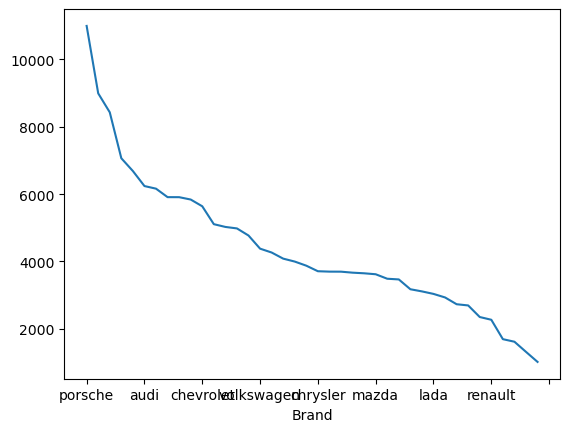

In [5]:
df.groupby("Brand")["Price"].mean().sort_values(ascending=False).plot()

#### Datos nulos:
Revisamos la cantidad de datos nulos en todas las columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

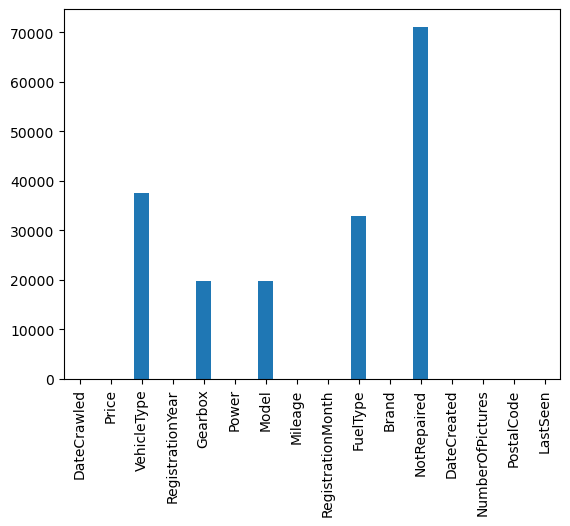

In [6]:
df.isnull().sum().plot(kind='bar')
df.dropna(how='all', inplace=True)
df.info()



#### Revisamos la distribución de los datos:

usando un escalado logaritmico para no omitir las cantidades pequeñas

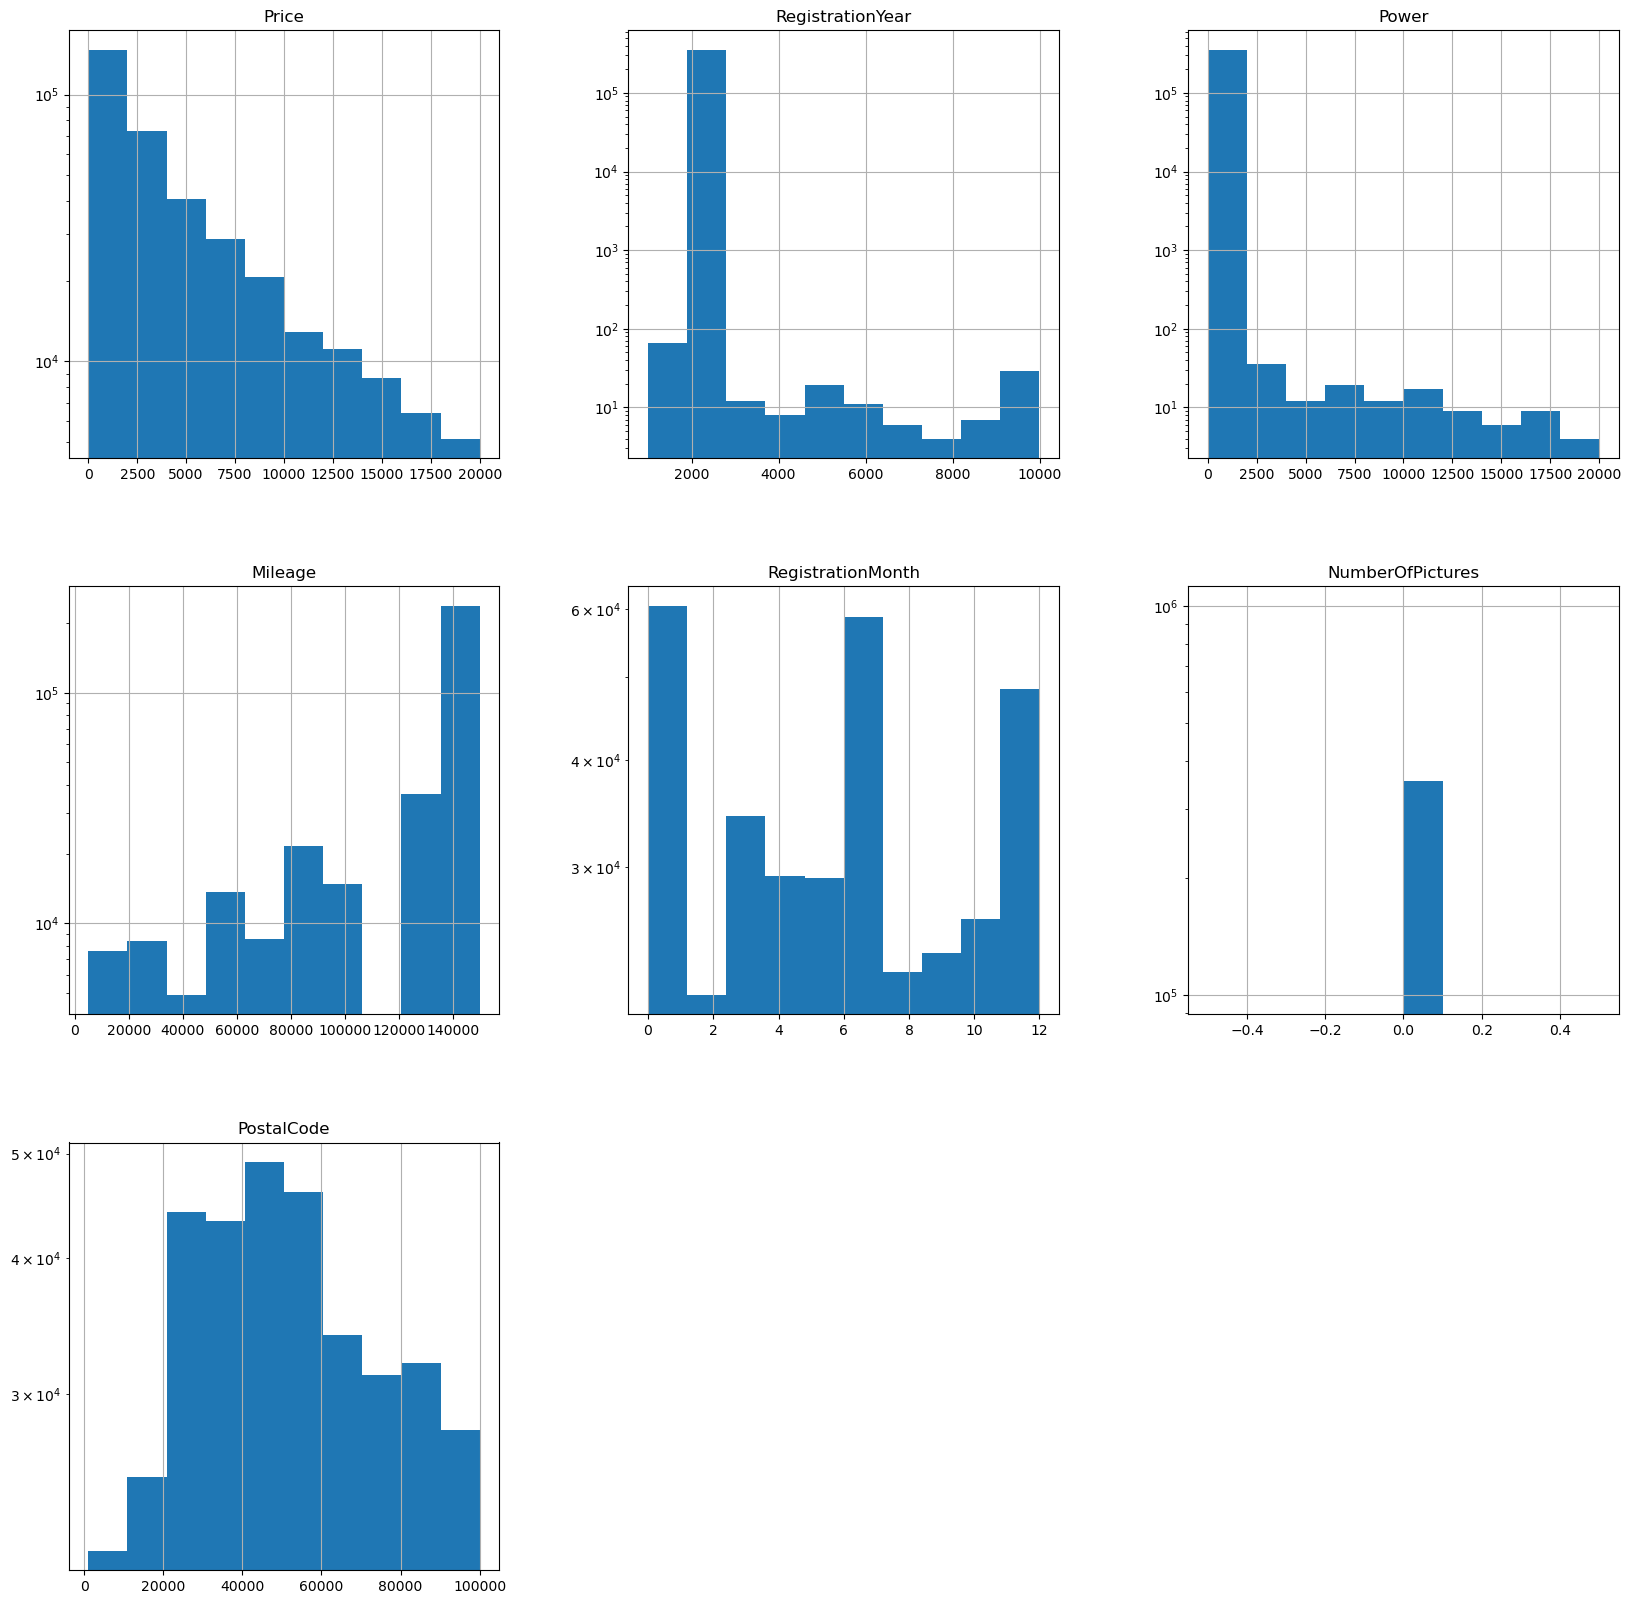

In [7]:
df.hist(figsize=(20, 20),log=True)
plt.show()

Procedemos a revisar la correlación de las variables, haciendo enfasis en la correlación del precio con las demas:

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Mileage,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


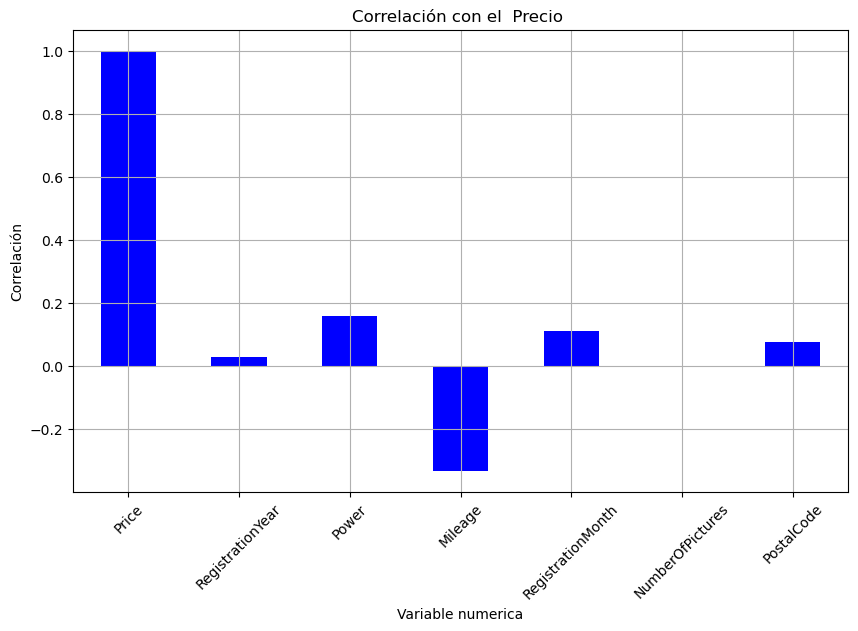

In [8]:
numeric=df.select_dtypes(include=['int64']).columns
df[numeric].corr()["Price"].plot(kind="bar",
                     figsize=(10, 6), 
                     color='blue',                     
                     title='Correlación con el  Precio ', 
                     xlabel='Variable numerica', 
                     ylabel='Correlación',
                     rot=45,
                     grid= True)
df[df.select_dtypes(include=['int64']).columns].corr()


## Observaciones:
- Existen caracteristicas (columnas) de nula importancia para los modelos.
- "Notrepaired" debe ser codificado con 0, 1 y nan, quitar el "yes" y "no".
- Notamos que el precio minimo es cero, lo cual debe ser una entrada erronea.
- notamos que la potencia minima tambien es cero, tambien debe ser una entrada erronea.
- notamos que el año de registro minimo es 0 y maximo es 9999 que deben ser otro error.
- existe una importante cantidad de datos nulos en multiples columnas.
- El promedio y la media del precio no coinciden


## Pre-Procesamiento de datos: 
Mejoraremos la calidad del dataframe abordando las observaciones hechas.

### Caracteristicas innecesarias.

Del diccionario de datos podemos determinar que caracteristicas no son relevantes para los modelos, retiramos dichas caracteristicas innecesarias y cualquier entrada duplicada:

In [9]:
df.drop(["PostalCode","LastSeen","NumberOfPictures","DateCreated","RegistrationMonth","DateCrawled"],axis=1,inplace=True)
df.drop_duplicates(inplace=True)


### Codificar "NotRepaired" y rellenar valores faltantes.

In [10]:
df.loc[df["NotRepaired"]=="yes","NotRepaired"]=1
df.loc[df["NotRepaired"]=="no","NotRepaired"]=0

df.fillna({"NotRepaired":"NaN"}, inplace=True)

display(df["NotRepaired"].unique())

array(['NaN', 1, 0], dtype=object)

### Features y objetivos erroneos
Exploramos el objetivo y un par de caracteristicas, pues no deberia haber entradas con precio ni potencia cero, al igual que con años superiores al actual:

In [11]:

print("Elementos con precio igual a cero:",df[df["Price"]==0]["Price"].count())

print("Elementos con potencia igual a cero:",df[df["Power"]==0]["Power"].count())
print("Elementos con un año superior al  actual:",df[df["RegistrationYear"]>2024]["RegistrationYear"].count())
print("Elementos con un año inferior a 1900:",df[df["RegistrationYear"]<1900]["RegistrationYear"].count())




Elementos con precio igual a cero: 8904
Elementos con potencia igual a cero: 35978
Elementos con un año superior al  actual: 99
Elementos con un año inferior a 1900: 63


#### Precio:
Buscamos mas a fondo la distribución del precio:

In [12]:
df.groupby("Price").count().head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
Price,,,,,,,,,
0,6015,8904,7118,8904,7220,8904,6211,8904,8904
1,670,1075,762,1075,867,1075,701,1075,1075
2,8,12,9,12,10,12,10,12,12
3,4,7,4,7,4,7,4,7,7
4,0,1,0,1,0,1,0,1,1
5,15,26,13,26,21,26,10,26,26
7,1,3,1,3,2,3,2,3,3
8,0,6,0,6,1,6,0,6,6
9,4,7,4,7,5,7,4,7,7


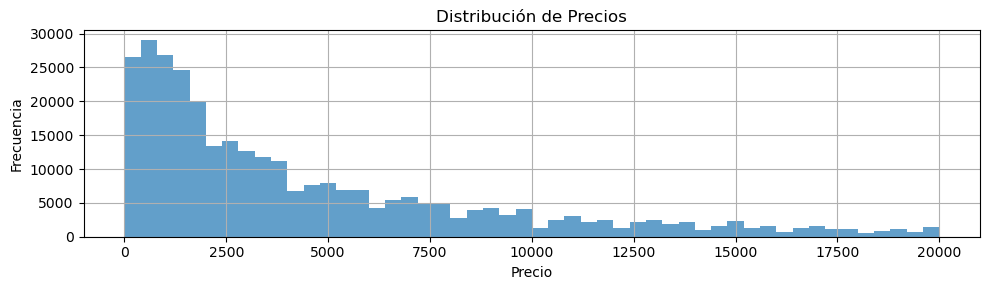

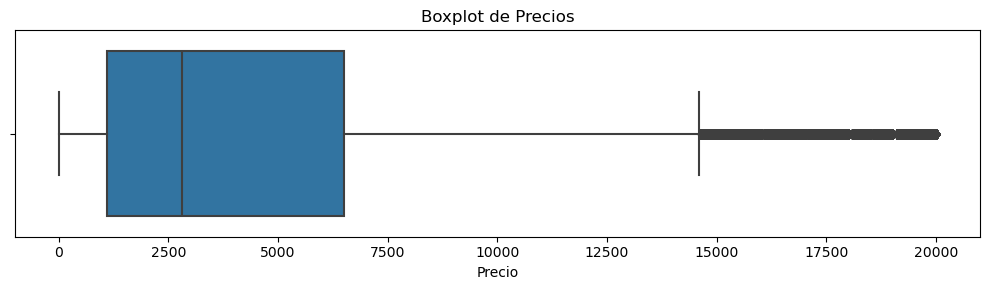

In [13]:
plt.figure(figsize=(10, 3))

df['Price'].plot(kind='hist', bins=50, alpha=0.7)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Price'])
plt.title('Boxplot de Precios')
plt.xlabel('Precio')

plt.tight_layout()
plt.show()



##### KNN imputer:
Notamos que hay bastantes entradas con valor cero y uno que deben ser corregidas, dichas entradas seran sustituidas a través de un algoritmo de *KNN Imputer*, este rellena los valores a traves de una cantidad de vecinos cercanos. 

Tambien tenemos multiples valores atipicos con precios bastante altos, estos datos llevaran a sobreestimar precios en los modelos por lo que los datos por encima del bigote superior seran retirados:

$$OutLiers>Q_3+1.5*(Q_3-Q_1)$$

In [14]:
'''df.loc[df["Price"] == 0, "Price"] =df[(df["Price"]!=0)&(df["Price"]!=1)]["Price"].median()
df.loc[df["Price"] == 1, "Price"] =df[(df["Price"]!=0)&(df["Price"]!=1)]["Price"].median()

# Calculate the value of the upper whisker
Bigote_superior = df['Price'].quantile(0.75) + (1.5 * (df['Price'].quantile(0.75) - df['Price'].quantile(0.25)))

df = df[df['Price'] < Bigote_superior].reset_index(drop=True)

df["Price"].median()
'''

'df.loc[df["Price"] == 0, "Price"] =df[(df["Price"]!=0)&(df["Price"]!=1)]["Price"].median()\ndf.loc[df["Price"] == 1, "Price"] =df[(df["Price"]!=0)&(df["Price"]!=1)]["Price"].median()\n\n# Calculate the value of the upper whisker\nBigote_superior = df[\'Price\'].quantile(0.75) + (1.5 * (df[\'Price\'].quantile(0.75) - df[\'Price\'].quantile(0.25)))\n\ndf = df[df[\'Price\'] < Bigote_superior].reset_index(drop=True)\n\ndf["Price"].median()\n'

In [15]:
# Crear un imputer KNN para reemplazar los valores faltantes de 'Price'
numeric=df.select_dtypes(include=['int64', 'float64']).columns


df['Price'].replace({1: np.nan, 0: np.nan}, inplace=True)

imputer = KNNImputer(missing_values=np.nan,n_neighbors=2, copy=False)

df_price_zero_one = df
# Aplicar el imputer KNN solo a estos valores
imputer.fit_transform(df_price_zero_one[numeric])



array([[4.800e+02, 1.993e+03, 0.000e+00, 1.500e+05],
       [1.830e+04, 2.011e+03, 1.900e+02, 1.250e+05],
       [9.800e+03, 2.004e+03, 1.630e+02, 1.250e+05],
       ...,
       [1.199e+03, 2.000e+03, 1.010e+02, 1.250e+05],
       [9.200e+03, 1.996e+03, 1.020e+02, 1.500e+05],
       [3.400e+03, 2.002e+03, 1.000e+02, 1.500e+05]])

In [16]:
df_price_zero_one.info()

display(df_price_zero_one.groupby("Price")["Price"].mean().sort_values(ascending=False).unique())


<class 'pandas.core.frame.DataFrame'>
Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             299350 non-null  float64
 1   VehicleType       274770 non-null  object 
 2   RegistrationYear  309329 non-null  int64  
 3   Gearbox           292122 non-null  object 
 4   Power             309329 non-null  int64  
 5   Model             290968 non-null  object 
 6   Mileage           309329 non-null  int64  
 7   FuelType          278565 non-null  object 
 8   Brand             309329 non-null  object 
 9   NotRepaired       309329 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 26.0+ MB


array([2.0000e+04, 1.9999e+04, 1.9998e+04, ..., 4.0000e+00, 3.0000e+00,
       2.0000e+00])

In [17]:
df["Price"]=df_price_zero_one["Price"].astype(float)

# Calculate the value of the upper whisker
Bigote_superior = df['Price'].quantile(0.75) + (1.5 * (df['Price'].quantile(0.75) - df['Price'].quantile(0.25)))

df = df[df['Price'] < Bigote_superior].reset_index(drop=True)

df["Price"].median()


2700.0

Revisamos el resultado:

In [18]:
df.groupby("Price").count().head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
Price,,,,,,,,,
2.0,8,12,9,12,10,12,10,12,12
3.0,4,7,4,7,4,7,4,7,7
4.0,0,1,0,1,0,1,0,1,1
5.0,15,26,13,26,21,26,10,26,26
7.0,1,3,1,3,2,3,2,3,3
8.0,0,6,0,6,1,6,0,6,6
9.0,4,7,4,7,5,7,4,7,7
10.0,36,81,35,81,66,81,41,81,81
11.0,1,5,1,5,3,5,1,5,5


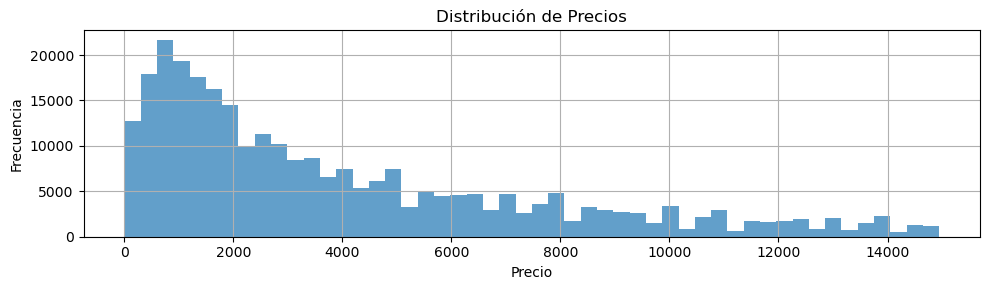

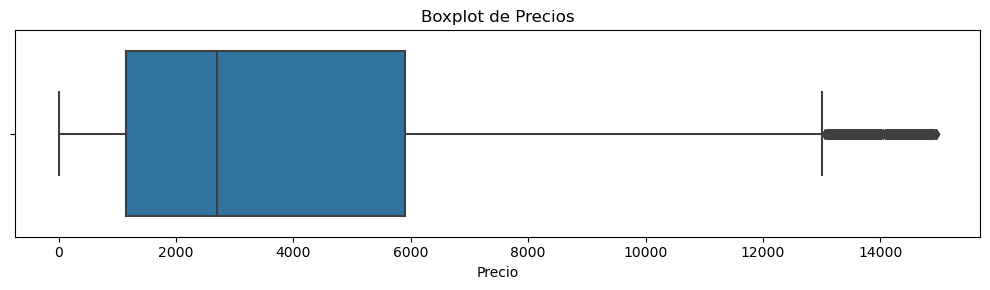

In [19]:
plt.figure(figsize=(10, 3))

df['Price'].plot(kind='hist', bins=50, alpha=0.7)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Price'])
plt.title('Boxplot de Precios')
plt.xlabel('Precio')

plt.tight_layout()
plt.show()


#### Año de registro:
Ahora revisaremos el año de registro.

In [20]:
df.groupby("RegistrationYear").count().head(10)

,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
RegistrationYear,,,,,,,,,
1000,26,0,2,26,13,26,4,26,26
1001,1,0,0,1,1,1,0,1,1
1039,1,0,0,1,0,1,1,1,1
1111,1,0,0,1,0,1,0,1,1
1234,4,0,0,4,2,4,1,4,4
1255,1,0,0,1,0,1,0,1,1
1300,2,0,0,2,2,2,0,2,2
1400,1,0,1,1,1,1,1,1,1
1500,3,0,2,3,2,3,0,3,3


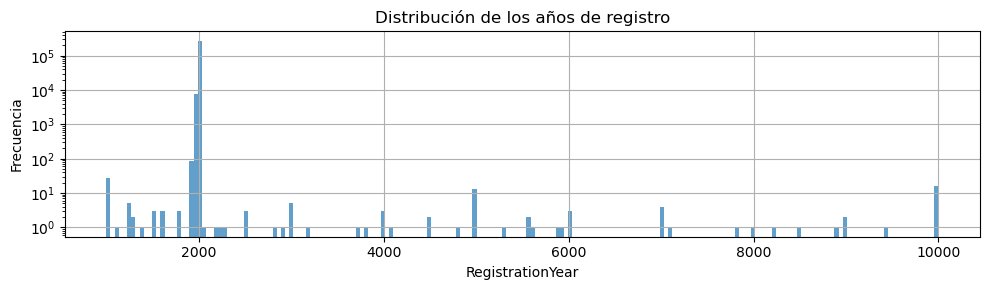

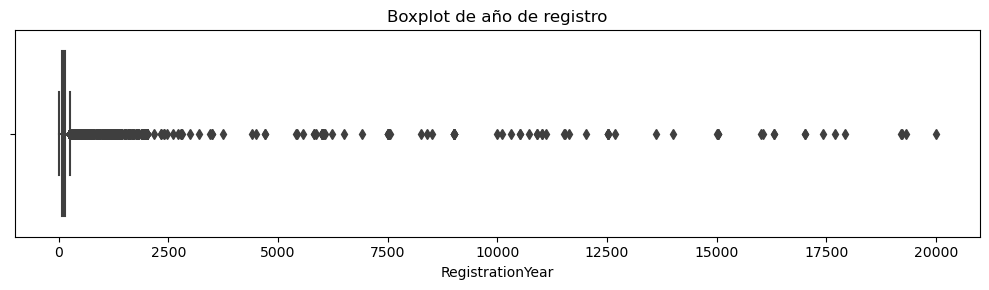

In [21]:
plt.figure(figsize=(10, 3))

df['RegistrationYear'].plot(kind='hist', bins=200, alpha=0.7, log=True)
plt.title('Distribución de los años de registro')
plt.xlabel('RegistrationYear')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Power'])
plt.title('Boxplot de año de registro')
plt.xlabel('RegistrationYear')

plt.tight_layout()
plt.show()

Tenemos claro que los registros anteriores a 1900 y superiores a 2024 deben ser erroneos y seran descartados.

Nuevamente reemplazaremos estos datos con la mediana para evitar alterar la distribución.

In [22]:

df.loc[df["RegistrationYear"] >2024 , "RegistrationYear"] =df[df["RegistrationYear"]!=0]["RegistrationYear"].median()
df.loc[df["RegistrationYear"] <1900, "RegistrationYear"] =df[df["RegistrationYear"]!=0]["RegistrationYear"].median()

print(df["RegistrationYear"].unique())
df[df["RegistrationYear"]!=0]["RegistrationYear"].median()

[1993 2004 2001 2008 1995 2014 1998 2005 1910 2016 2007 2009 2002 2018
 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000 1992
 2013 1996 1985 1989 2011 1982 1976 1973 2015 1969 1971 1987 1986 1983
 1988 1980 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961
 1966 1975 1963 1964 1960 1958 1967 1941 1962 1929 1957 1949 1940 2019
 1937 1951 1959 1954 1953 1950 1952 1942 1956 1935 1936 1923 1930 1944
 1938 1934 1943 1928 1932 1931 1948 1946]


2003.0

Revisamos el efecto de los cambios:

In [23]:
df.groupby("RegistrationYear").count().head(10)

,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
RegistrationYear,,,,,,,,,
1910,41,11,13,41,20,41,12,41,41
1923,2,2,2,2,2,2,2,2,2
1925,1,1,0,1,0,1,0,1,1
1928,2,2,1,2,2,2,1,2,2
1929,4,4,3,4,2,4,3,4,4
1930,1,1,1,1,1,1,1,1,1
1931,1,1,1,1,1,1,1,1,1
1932,2,2,1,2,2,2,1,2,2
1934,2,2,1,2,1,2,2,2,2


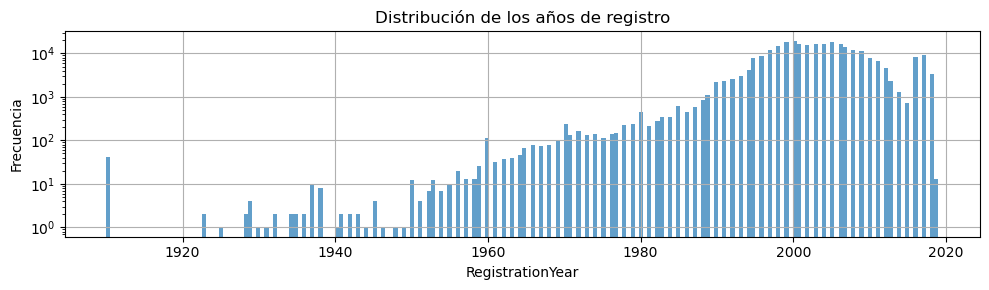

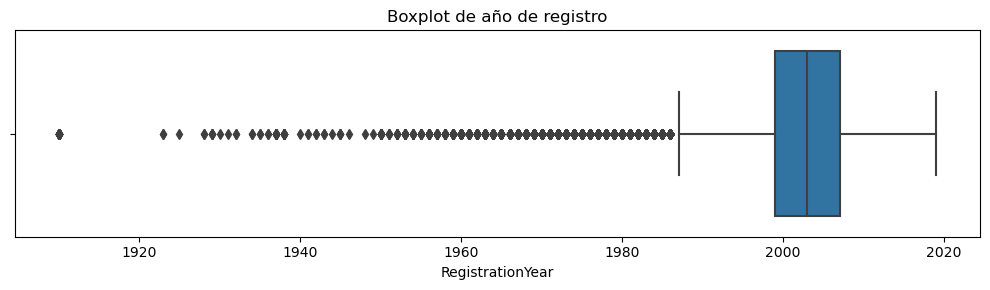

In [24]:
plt.figure(figsize=(10, 3))

df['RegistrationYear'].plot(kind='hist', bins=200, alpha=0.7, log=True)
plt.title('Distribución de los años de registro')
plt.xlabel('RegistrationYear')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['RegistrationYear'])
plt.title('Boxplot de año de registro')
plt.xlabel('RegistrationYear')

plt.tight_layout()
plt.show()

#### Potencia:

Ahora exploramos los valores mas comunes de pontencia y su distribución usando un ajuste logaritmico al eje **y** para apreciar la cantidad de outliers

In [25]:
df.groupby("Power").count().head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Model,Mileage,FuelType,Brand,NotRepaired
Power,,,,,,,,,
0,32076,20973,32076,22920,27568,32076,23465,32076,32076
1,24,21,24,20,17,24,19,24,24
2,9,8,9,8,4,9,8,9,9
3,9,8,9,9,1,9,8,9,9
4,26,23,26,26,5,26,22,26,26
5,93,86,93,89,14,93,87,93,93
6,11,11,11,11,4,11,8,11,11
7,10,10,10,9,3,10,10,10,10
8,7,6,7,6,5,7,6,7,7


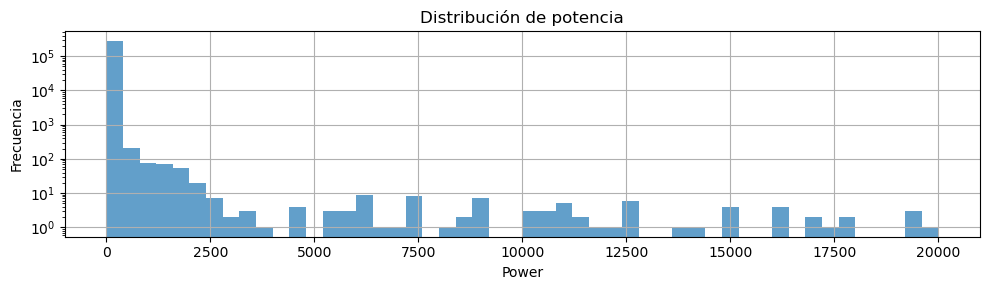

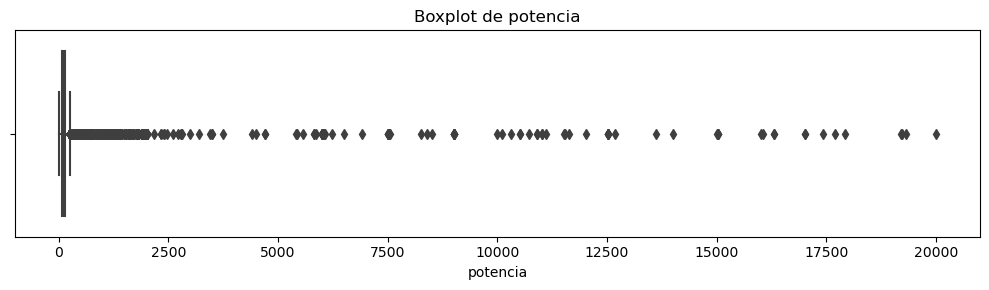

In [26]:
plt.figure(figsize=(10, 3))

df['Power'].plot(kind='hist', bins=50, alpha=0.7,log=True)
plt.title('Distribución de potencia')
plt.xlabel('Power')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Power'])
plt.title('Boxplot de potencia')
plt.xlabel('potencia')

plt.tight_layout()
plt.show()

Notamos que existe un exceso de datos con valor cero, al igual que muchos datos con valores irrealmente bajos, necesitamos corregir esta caracteristica, para ello haremos un pequeño modelo de regresión lineal que calcule los valores para las entradas con potencia cero, luego descartareamos las entradas con valores atipicamente pequeños y grandes.

In [27]:
features = df[['Price', 'RegistrationYear', 'Mileage']]
target = df['Power']

# Dividir los datos en entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(features_train, target_train)

# Predecir los valores de Power para las entradas con valores cero
missing_power = df[df['Power']==0]

predicted_power = model.predict(missing_power[['Price', 'RegistrationYear', 'Mileage']])

df.loc[df['Power']==0, 'Power'] = np.int64(predicted_power)

Descartamos outliers con la distancai intercuartil:

In [28]:
Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1

Bigote_inferior = Q1 - 1.5 * IQR
Bigote_superior= Q1 + 1.5 * IQR

# Identificar valores atípicamente pequeños
df = df[df['Power'] > Bigote_inferior].reset_index(drop=True)
df = df[df['Power'] < Bigote_superior].reset_index(drop=True)

Verificamos el efecto del procesamiento:

In [29]:
df.groupby(by='Power').count().head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Model,Mileage,FuelType,Brand,NotRepaired
Power,,,,,,,,,
1,24,21,24,20,17,24,19,24,24
2,9,8,9,8,4,9,8,9,9
3,9,8,9,9,1,9,8,9,9
4,26,23,26,26,5,26,22,26,26
5,93,86,93,89,14,93,87,93,93
6,11,11,11,11,4,11,8,11,11
7,10,10,10,9,3,10,10,10,10
8,7,6,7,6,5,7,6,7,7
9,6,5,6,6,3,6,5,6,6


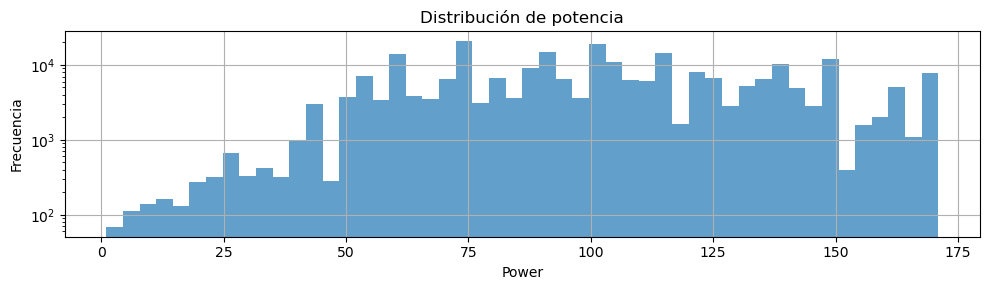

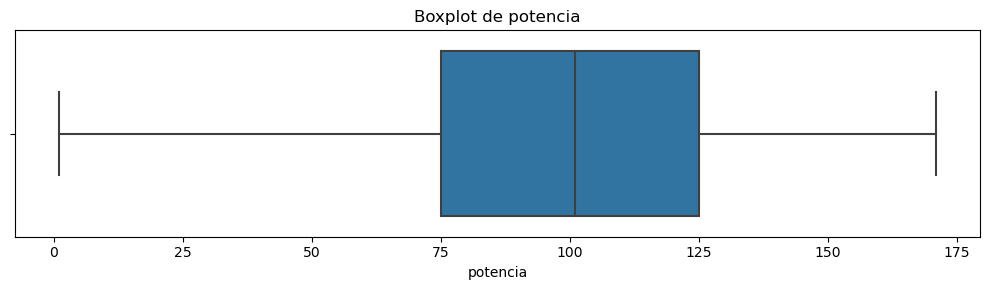

In [30]:
plt.figure(figsize=(10, 3))

df['Power'].plot(kind='hist', bins=50, alpha=0.7,log=True)
plt.title('Distribución de potencia')
plt.xlabel('Power')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Power'])
plt.title('Boxplot de potencia')
plt.xlabel('potencia')

plt.tight_layout()
plt.show()

### Datos nulos

In [31]:
#df.dropna(inplace=True)
df.dropna(how='all', inplace=True)
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253334 entries, 0 to 253333
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             253334 non-null  float64
 1   VehicleType       224280 non-null  object 
 2   RegistrationYear  253334 non-null  int64  
 3   Gearbox           239065 non-null  object 
 4   Power             253334 non-null  int64  
 5   Model             239009 non-null  object 
 6   Mileage           253334 non-null  int64  
 7   FuelType          228095 non-null  object 
 8   Brand             253334 non-null  object 
 9   NotRepaired       253334 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 19.3+ MB


,Price,RegistrationYear,Power,Mileage
count,253334.000000,253334.000000,253334.000000,253334.000000
mean,3557.412080,2002.968453,102.256420,128026.597298
std,3318.884181,7.483438,33.526883,37543.348978
min,2.000000,1910.000000,1.000000,5000.000000
25%,1000.000000,1999.000000,75.000000,125000.000000
50%,2400.000000,2003.000000,101.000000,150000.000000
75%,5000.000000,2007.000000,125.000000,150000.000000
max,14940.000000,2019.000000,171.000000,150000.000000


In [32]:
df.isnull().sum()


Price                   0
VehicleType         29054
RegistrationYear        0
Gearbox             14269
Power                   0
Model               14325
Mileage                 0
FuelType            25239
Brand                   0
NotRepaired             0
dtype: int64

Como tenemos aun datos faltantes en columnas categoricas y modelos como "catboost" no aceptan "nan", rellenaremos con "Nan" al igual que se hizo para "NotRepaired":


In [33]:
df.fillna(value='NaN', inplace=True)
df.isnull().sum()


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Mileage             0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

### Codificamos con "One Hot Encoding" (OHE) el set para poder usar el arbol aleatorio de regresión y regresión lineal:

Esto debido a que la regresión lineal y el árbol de regresión no funciona con caracteristicas categoricas, al usar OHE, las caracteristicas categoricas se transforman en un "True" o "False", que se interpreta como "1" o "0", permitiendo a estos  modelos obtener información de dichas caracteristicas.

Por otro lado, el resto de modelos no requieren de OHE para obtener información de las caracteristicas categoricas.

In [34]:
df_ohe=(pd.get_dummies(df,drop_first=True))


In [35]:
display(df.columns)
display(df_ohe.columns)

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

Index(['Price', 'RegistrationYear', 'Power', 'Mileage', 'VehicleType_bus',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small',
       ...
       'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_1', 'NotRepaired_NaN'],
      dtype='object', length=309)

### División del dataset:
Dividiremos los datos de ambos dataframes en datos de entrenamiento y de validación.
- train: 75%
- validation: 25%

Dataset normal

In [36]:
features = df.drop("Price",axis=1)
target = df["Price"]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=54321, test_size =0.75) 


Dataset con one hot encoding:

In [37]:
features = df_ohe.drop("Price",axis=1)
target = df_ohe["Price"]

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features, 
                        target, 
                        random_state=54321, 
                        test_size =0.75) 


#### Escalado de características:


En algunos modelos necesario escalar los datos de las categoricas numericas para que no se considere ninguna categoria privilegiada sobre las demas; tambien es necesario que el Escalado se haga sobre el conjunto de entrenamiento y luego se aplique al conjunto de validación con los mismos parametros para evitar el "data leakeage".

Haremos dos sets de escalados, uno para las las categorias codificadas y otro para las no codificadas, esto con el fin de que cada modelo reciba las caracteristicas correctamente procesadas para su optimo funcionamiento.

In [38]:
Numeric = features_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
scaler.fit(features_train[Numeric])
features_train[Numeric]=scaler.transform(features_train[Numeric])
features_valid[Numeric]=scaler.transform(features_valid[Numeric])

scaler2 = StandardScaler()
scaler2.fit(features_train_ohe[Numeric])
features_train_ohe[Numeric]=scaler2.transform(features_train_ohe[Numeric])
features_valid_ohe[Numeric]=scaler2.transform(features_valid_ohe[Numeric])

# Entrenamiento de  modelos:

Debido a que nuestro objetivo es cuantitativo, ocuparemos modelos de regresión tales como Bosque aleatorio de regresión, árbol aleatorio de regresión, regresión lineal y metodos de potenciación de gradiente, entrenaremos los modelos en dicho orden.


### Bosque de decisión de regresión:
Modelo de bosque de regresión tradicional de parte de sklearn, al estar compuesto de multiples arboles suele ser tener menor error y mayor tiempo de entrenamiento.

Primero usaremos este bosque para crear un analisis de importancia de caracteristicas; por esto mismo no aplicaremos cross validation, pues ahora mismo no nos importa tanto la precisión del error, si no las caracteristicas que componen el modelo, a la vez iteraremos a través de multiples parametros para encontrar un aproximado de hiperparametros.

In [39]:
'''%%time 
start_time = time.time()

best_error = 10000 # configura el inicio de RECM
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=54321, n_estimators=est , max_depth=depth)
        model.fit(features_train_ohe,target_train_ohe) 
        predictions_valid_ohe = model.predict(features_valid_ohe) 
        error = (mean_squared_error(target_valid_ohe,predictions_valid_ohe))**0.5 
        #print("Validación RECM para los n_estimators de", est, ", depth=", depth, "is", error)
        if error < best_error: 
            best_error = error
            best_est = est
            best_depth = depth
error_forest=best_error
end_time = time.time()
forest_time= end_time - start_time

print("\nRECM del mejor modelo en el conjunto de validación:", error_forest,"\nHiperparametros:\n- n_estimators:", best_est, "\n- best_depth:", best_depth)
'''

'%%time \nstart_time = time.time()\n\nbest_error = 10000 # configura el inicio de RECM\nbest_est = 0\nbest_depth = 0\nfor est in range(10, 51, 10):\n    for depth in range (1, 11):\n        model = RandomForestRegressor(random_state=54321, n_estimators=est , max_depth=depth)\n        model.fit(features_train_ohe,target_train_ohe) \n        predictions_valid_ohe = model.predict(features_valid_ohe) \n        error = (mean_squared_error(target_valid_ohe,predictions_valid_ohe))**0.5 \n        #print("Validación RECM para los n_estimators de", est, ", depth=", depth, "is", error)\n        if error < best_error: \n            best_error = error\n            best_est = est\n            best_depth = depth\nerror_forest=best_error\nend_time = time.time()\nforest_time= end_time - start_time\n\nprint("\nRECM del mejor modelo en el conjunto de validación:", error_forest,"\nHiperparametros:\n- n_estimators:", best_est, "\n- best_depth:", best_depth)\n'

In [40]:
param_grid = {
    'n_estimators': range(10, 71, 10),
    'max_depth': range(1, 11)
}
model = RandomForestRegressor(random_state=54321)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()

grid_search.fit(features_train_ohe, target_train_ohe)

best_params = grid_search.best_params_
best_error = -grid_search.best_score_
error_forest=best_error

forest_time = time.time() - start_time

print("\nRECM del mejor modelo en el conjunto de validación:", best_error)
print("Hiperparámetros:\n- n_estimators:", best_params['n_estimators'], "\n- max_depth:", best_params['max_depth'])
print("Tiempo de ejecución:", forest_time, "segundos")


RECM del mejor modelo en el conjunto de validación: 1482.8133861876559
Hiperparámetros:
- n_estimators: 70 
- max_depth: 10
Tiempo de ejecución: 155.88602495193481 segundos


#### Analisis de importancia de caracteristicas.

Haremos un analisis de importancia de caracteristicas:

In [41]:
best_model = RandomForestRegressor(random_state=54321, 
                n_estimators=best_params['n_estimators'], 
                max_depth=best_params['max_depth'])
                
best_model.fit(features_train_ohe, target_train_ohe)



RandomForestRegressor(max_depth=10, n_estimators=70, random_state=54321)

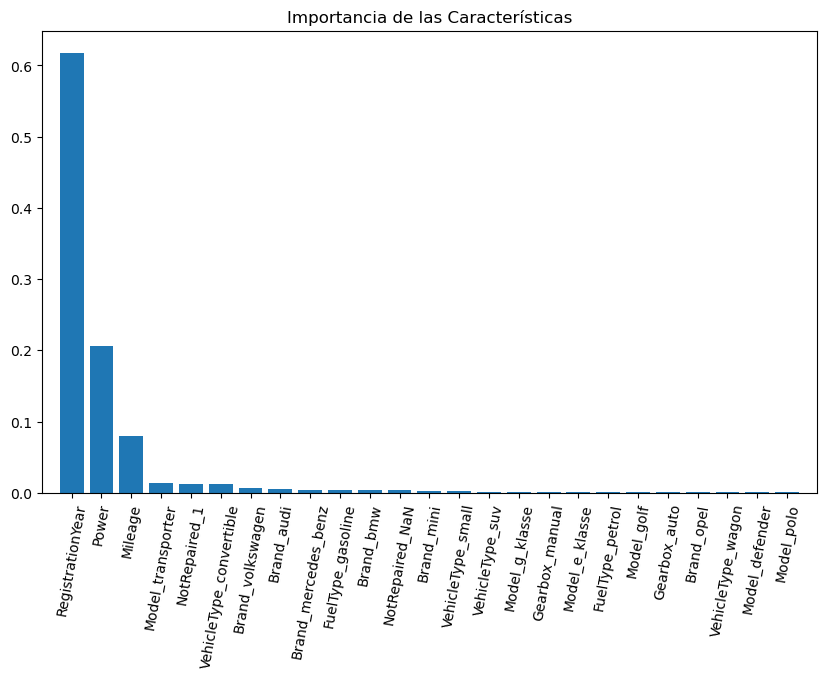

In [42]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = features_train_ohe.columns

n=25
plt.figure(figsize=(10, 6))

plt.title("Importancia de las Características")


plt.bar(range(n), importances[indices[:n]])
plt.xticks(range(n), feature_names[indices[:n]], rotation=80)
plt.xlim([-1, n])
plt.show()

Buscaremos como mejorar la predicción del precio atendiendo las caracteristicas mas importantes y deshaciendonos de las que no poseen importancia.
- Vemos que "Brand" puede tener cierta relevancia.

Agruparemos las marcas en cuatro categorias para facilitar el entrenamiento.

- vemos que "model", "type" y "Gearbox" tiene muy poca relevancia.
Nos desharemos de estas categorias.


Para definir las categorias de "Brand", revisamos las marcas y sus preciós promedio, procedemos a crear una función que categorice respecto al precio promedio.

Brand
mini              7422.755797
jeep              6016.124555
dacia             5816.086849
land_rover        5701.614618
skoda             5255.636849
porsche           4734.908497
jaguar            4698.815789
chevrolet         4584.339109
audi              4558.457792
hyundai           4523.829366
bmw               4363.488430
mercedes_benz     4312.160768
toyota            4275.942588
kia               4252.811111
sonstige_autos    3959.153089
volkswagen        3862.911639
suzuki            3743.139063
seat              3596.472287
smart             3482.086441
honda             3363.935307
citroen           3355.588771
nissan            3322.523303
mazda             3240.316393
lada              3191.101010
alfa_romeo        3184.098907
volvo             3014.097640
peugeot           2977.624407
saab              2792.218750
ford              2723.755401
fiat              2704.871925
mitsubishi        2683.783081
subaru            2683.351724
opel              2648.810020
chry

<Axes: xlabel='Brand'>

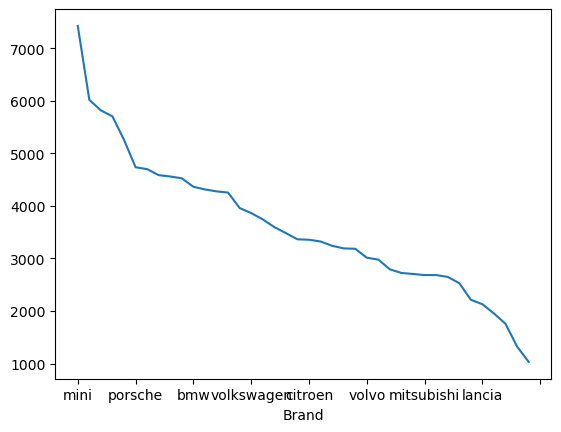

In [43]:
display(df.groupby("Brand")["Price"].mean().sort_values(ascending=False))

df.groupby("Brand")["Price"].mean().sort_values(ascending=False).plot()

In [44]:
def categorize_brand(price):
    luxury_threshold = 4500  
    high_price_threshold = 4000
    mid_price_threshold = 2000
    if price >= luxury_threshold:
        return 3
    elif price >= high_price_threshold:
        return 2
    elif price >= mid_price_threshold:
        return 1
    else:
        return 0

In [45]:
precio_marca = df.groupby("Brand")["Price"].mean()
#print(precio_marca.sort_values(ascending=False))
brand_categories = precio_marca.apply(categorize_brand)

df['Brand_Category'] = df['Brand'].map(brand_categories).fillna('Unknown')

df_ohe['Brand_Category'] = df['Brand'].map(brand_categories).fillna('Unknown')
df.drop(["Brand","Model","VehicleType","Gearbox","FuelType"],axis=1,inplace=True)


Hemos aplicado la función y desechado las caracteristicas "Brand", "Type", "FuelType" y "Model".


In [46]:
df

,Price,RegistrationYear,Power,Mileage,NotRepaired,Brand_Category
0,480.0,1993,92,150000,NaN,1
1,9800.0,2004,163,125000,NaN,3
2,1500.0,2001,75,150000,0,1
3,3600.0,2008,69,90000,0,3
4,650.0,1995,102,150000,1,2
...,...,...,...,...,...,...
253329,5250.0,2016,150,150000,0,1
253330,2200.0,2005,44,20000,NaN,1
253331,1199.0,2000,101,125000,0,1
253332,9200.0,1996,102,150000,0,1


##### Reprocesamiento:
Ahora tenemos que reprocesar el dataframe para entrenar modelos.

###### Encoding

In [47]:
df_ohe=(pd.get_dummies(df,drop_first=True))


###### División:

In [48]:
features = df_ohe.drop("Price",axis=1)
target = df_ohe["Price"]

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features, 
                        target, 
                        random_state=54321, 
                        test_size =0.75) 


###### Escalado:

In [49]:
scaler2 = StandardScaler()
scaler2.fit(features_train_ohe[Numeric])
features_train_ohe[Numeric]=scaler2.transform(features_train_ohe[Numeric])
features_valid_ohe[Numeric]=scaler2.transform(features_valid_ohe[Numeric])

##### Segunda busqueda de importancias:

In [50]:
best_model = RandomForestRegressor(random_state=54321, 
                n_estimators=best_params['n_estimators'], 
                max_depth=best_params['max_depth'])
                
best_model.fit(features_train_ohe, target_train_ohe)

RandomForestRegressor(max_depth=10, n_estimators=70, random_state=54321)

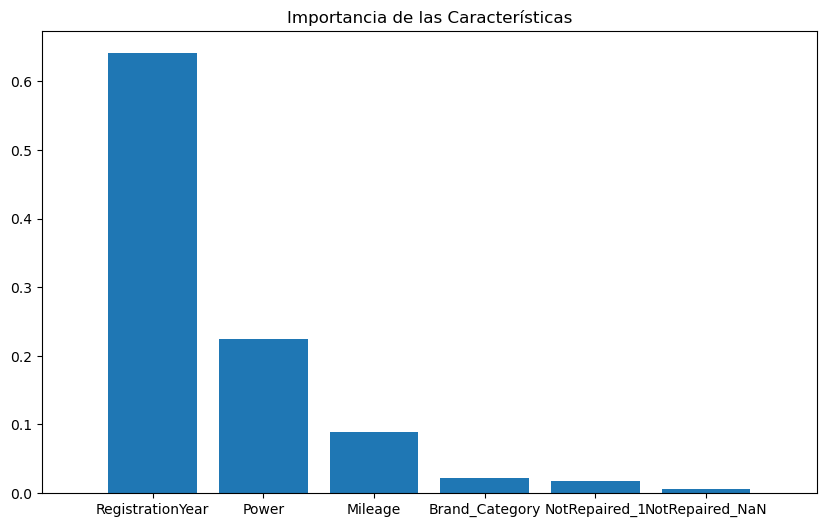

In [51]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = features_train_ohe.columns

n=6
plt.figure(figsize=(10, 6))

plt.title("Importancia de las Características")


plt.bar(range(n), importances[indices[:n]])
plt.xticks(range(n), feature_names[indices[:n]], rotation=0)
plt.xlim([-1, n])
plt.show()

Con este grafico podemos finalmente entrenar nuestros modelos de forma optima.
Como todas las caracteristicas ya son numericas, este dataframe sirve para todos los modelos por entrenar.

In [52]:
features_train=features_train_ohe
features_valid=features_valid_ohe

### Árbol de decisión de regresión:

Modelo de árbol de decisión de regresión tradicional de parte de sklearn, este usa los datasets ya definidos sin cambio alguno, iteraremos a través de multiples hiperparametros.

In [53]:
'''%%time 
start_time = time.time()

best_model = None
best_result = 10000
best_depth = 0
for depth in range(7, 15):
    model = DecisionTreeRegressor(max_depth= depth, random_state=12345)
    model.fit(features_train_ohe,target_train_ohe) 
    predictions_valid_ohe = model.predict(features_valid_ohe) 
    result = (mean_squared_error(target_valid_ohe,predictions_valid_ohe))**0.5
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
    
end_time = time.time()
tree_time= end_time - start_time
error_tree=best_result
print(f"RECM del mejor modelo en el conjunto de validación: {best_result} con una profundidad maxima de {best_depth})")
'''

'%%time \nstart_time = time.time()\n\nbest_model = None\nbest_result = 10000\nbest_depth = 0\nfor depth in range(7, 15):\n    model = DecisionTreeRegressor(max_depth= depth, random_state=12345)\n    model.fit(features_train_ohe,target_train_ohe) \n    predictions_valid_ohe = model.predict(features_valid_ohe) \n    result = (mean_squared_error(target_valid_ohe,predictions_valid_ohe))**0.5\n    if result < best_result:\n        best_model = model\n        best_result = result\n        best_depth = depth\n    \nend_time = time.time()\ntree_time= end_time - start_time\nerror_tree=best_result\nprint(f"RECM del mejor modelo en el conjunto de validación: {best_result} con una profundidad maxima de {best_depth})")\n'

In [54]:
%%time 
start_time = time.time()
model = DecisionTreeRegressor(random_state=12345)

param_grid = {
    'max_depth': range(7, 15)  
}

scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,  
    cv=4,            
    verbose=0,
    n_jobs=-1       
)

grid_search.fit(features_train_ohe, target_train_ohe)

# Obtener los mejores parámetros y el mejor score
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_


end_time = time.time()
tree_time= end_time - start_time
error_tree=best_rmse
print(f"RECM del mejor modelo en el conjunto de validación: {best_rmse} \ncon una profundidad maxima de {best_params}")


RECM del mejor modelo en el conjunto de validación: 1660.3956876189454 
con una profundidad maxima de {'max_depth': 10}
CPU times: total: 62.5 ms
Wall time: 398 ms


### Regresión lineal:
Aplicaremos regresión lineal, normal, con Ridge y con Lasso:

In [55]:
%%time
start_time=time.time()
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe) 
predictions_valid_ohe = model.predict(features_valid_ohe) 

result_lineal =root_mean_squared_error(target_valid_ohe,predictions_valid_ohe)
print("RECM del modelo de regresión lineal en el conjunto de validación:", result_lineal)
error_regresion=result_lineal
end_time = time.time()
regresión_time= end_time - start_time



RECM del modelo de regresión lineal en el conjunto de validación: 2380.036308338863
CPU times: total: 0 ns
Wall time: 15.6 ms


In [56]:
#  Ridge
start_time=time.time()

model_ridge = Ridge(alpha=2.0)
model_ridge.fit(features_train_ohe, target_train_ohe)
predictions_valid_ohe_ridge = model_ridge.predict(features_valid_ohe)

result_ridge = root_mean_squared_error(target_valid_ohe, predictions_valid_ohe_ridge)
print("RECM del modelo de regresión lineal usando Ridge en el conjunto de validación:", result_ridge)
error_ridge=result_ridge
end_time = time.time()
ridge_time= end_time - start_time



RECM del modelo de regresión lineal usando Ridge en el conjunto de validación: 2380.035387693249


In [57]:

# Añadido Lasso}
start_time=time.time()

model_lasso = Lasso(alpha=0.2)
model_lasso.fit(features_train_ohe, target_train_ohe)
predictions_valid_ohe_lasso = model_lasso.predict(features_valid_ohe)

result_lasso = root_mean_squared_error(target_valid_ohe, predictions_valid_ohe_lasso)
print("RECM del modelo de regresión lineal usando Lasso en el conjunto de validación:", result_lasso)
error_Lasso=result_ridge
end_time = time.time()
lasso_time= end_time - start_time



RECM del modelo de regresión lineal usando Lasso en el conjunto de validación: 2380.033258104831


Lo cual nos da un error razonable aunque no ideal.

### Catboost: Potenciación del gradiente
Ahora usaremos CatBoost para entrenar una potenciación del gradiente que se basa en arboles de decisión:

Para esto no es necesario usar el dataframe codificado con *OHE*, pero si es necesario indicarle al modelo que columnas son categoricas.
Así, primero obtenemos los indices de las columnas categoricas de "features_train":

In [58]:
categorias = features_train.select_dtypes(include=['object']).columns
print(categorias)
indices_categorias = [features_train.columns.get_loc(categoria) for categoria in categorias]
print("Índices de las columnas categóricas:", indices_categorias)


Index([], dtype='object')
Índices de las columnas categóricas: []


Tras ello, el algoritmo se implementa de forma muy similar a sklearn:

In [59]:
%%time
start_time= time.time()
best_error = 10000
best_est = 0
best_depth = 0

# Iterar sobre diferentes hiperparámetros
for est in range(50, 81, 10):
    for depth in range(5, 15):
        model = CatBoostRegressor(iterations=est, depth=depth, random_seed=54321, learning_rate=0.1,loss_function='RMSE',task_type="GPU", verbose=0)

        model.fit(features_train, target_train, cat_features=indices_categorias)
        predictions_valid = model.predict(features_valid)
        error = root_mean_squared_error(target_valid, predictions_valid)
        #print(f"Validación RECM para los n_estimators de {est}, depth={depth} es {error}")
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth
error_catboost=best_error
end_time = time.time()
catboost_time= end_time - start_time
print(f"RECM del mejor modelo en el conjunto de validación: {best_error}, n_estimators: {best_est}, best_depth: {best_depth}")


RECM del mejor modelo en el conjunto de validación: 1529.9206062603166, n_estimators: 80, best_depth: 14
CPU times: total: 46.4 s
Wall time: 46.1 s


In [60]:
%%time
model = CatBoostRegressor(random_seed=54321, learning_rate=0.1, loss_function='RMSE', task_type="GPU", verbose=0)

param_grid = {
    'iterations': range(50, 81, 10),
    'depth': range(5, 15)
}

scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,  
    cv=4,            
    verbose=1,
    n_jobs=1       
)

grid_search.fit(features_train, target_train, cat_features=indices_categorias)

best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_
error_catboost=best_rmse

print(f"Mejores parámetros: {best_params}")
print(f"Mejor RMSE en validación cruzada: {best_rmse}")


Fitting 4 folds for each of 40 candidates, totalling 160 fits
Mejores parámetros: {'depth': 14, 'iterations': 80}
Mejor RMSE en validación cruzada: 1545.5822483872753
CPU times: total: 3min 5s
Wall time: 3min 4s


In [61]:
error_catboost=best_rmse


Los parametros de entrenamiento vienen del modelo de bosque y arbol, iterando alrededor de los rangos que dieron mejores resultados para estos dos mencionados.


### LightGBM: potenciación de gradiente
Ahora entrenaremos un arbol a través de LightGBM, para esto primero tenemos que realizar un pequeño pre-proceso diferente a OHE a las caracteristicas categoricas:


In [62]:
'''categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for col in categorical_features:
    df[col] = df[col].astype('category').cat.codes
display(df)
df.info()
'''

"categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']\n\nfor col in categorical_features:\n    df[col] = df[col].astype('category').cat.codes\ndisplay(df)\ndf.info()\n"

Ahora volvemos a dividir el dataframe preprocesado en caracteristicas y objetivos, entrenamiento y validación:

In [63]:

'''features = df.drop("Price",axis=1)
target = df["Price"]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=54321, test_size =0.75) 
'''

'features = df.drop("Price",axis=1)\ntarget = df["Price"]\n\nfeatures_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=54321, test_size =0.75) \n'

LightGBM requiere definir sus datasets a través de "lgb.Dataset" indicandole que columnas son categoricas con:

```categorical_feature=indices_categorias```

y no liberando los dataframes 

```free_raw_data=False```

In [64]:

train_data = lgb.Dataset(features_train, label=target_train, free_raw_data=False)
valid_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data, free_raw_data=False)


Ahora entrenaremos el modelo de forma iterativa, donde se crea el diccionario "params" que define a los modelos, usando parametros similares a los modelos anteriores, como estar basado en potenciación del gradiente para arboles de decisión, buscar optmizar la raiz del error cuadratico medio, etc.

El concepto de cada parametro se encuentran en el codigo.

In [65]:

%%time
start_time=time.time()
best_error = 10000
best_est = 0
best_depth = 0

for est in range(50, 81, 10):
    for depth in range(5, 16):
        num_leaves = max(2, 2**depth - 1)
        params = {
            'objective': 'regression', #Tipo de modelo
            'metric': 'rmse', #Metrica objetivo
            'boosting_type': 'gbdt', #tipo de boosting, Gradient Boost Desicion Tree, 
            'num_leaves': num_leaves, #Cantidad de nodos finales del arbol, los cuales son ponderados para obtener el resultado final.
            'learning_rate': 0.1,
            #'n_estimators': est,
            'device': 'gpu',  # Usar GPU para el entrenamiento
            'verbose': -1  # disminuir la cantidad de información impresa por cada entrenamiento.

        }
        model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=est)
        predictions_valid = model.predict(features_valid)
        error = root_mean_squared_error(target_valid, predictions_valid)
        #print(f"Validación RECM para los n_estimators de {est}, depth={depth} es {error}")
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth

error_lightGBM=best_error
end_time = time.time()
lightGBM_time= end_time - start_time
print(f"RECM del mejor modelo en el conjunto de validación: {best_error}, n_estimators: {best_est}, best_depth: {best_depth}")


RECM del mejor modelo en el conjunto de validación: 1498.6597476462218, n_estimators: 70, best_depth: 8
CPU times: total: 1h 15min 36s
Wall time: 9min 27s


In [66]:
%%time
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'device': 'gpu',  # Usar GPU
    'verbose': 0
}
#num_leaves = max(2, 2**depth - 1)
num_leaves_values = [max(2,2**depth - 1) for depth in range(5, 16)]
n_estimators_values = range(50, 81, 10)

start_time = time.time()

best_error = 10000
best_params = None

for num_leaves in num_leaves_values:
    for n_estimators in n_estimators_values:
        params['num_leaves'] = num_leaves
        cv_results = lgb.cv(params, train_data, num_boost_round=n_estimators, 
                            nfold=4, metrics='rmse')
        #print("cv_results=",cv_results)
        mean_rmse = np.mean(cv_results["valid rmse-mean"])
        
        if mean_rmse < best_error:
            best_error = mean_rmse
            best_params = {
                'num_leaves': num_leaves,
                'n_estimators': n_estimators
            }

end_time = time.time()
lightGBM_time = end_time - start_time
error_lightGBM=best_error

print(f"\nRECM del mejor modelo en validación cruzada: {best_error}")
print(f"Mejores hiperparámetros -> n_estimators: {best_params['n_estimators']}, num_leaves: {best_params['num_leaves']}")


C:\Users\un-ma\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\un-ma\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\un-ma\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\un-ma\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
C:\Users\un-ma\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has


RECM del mejor modelo en validación cruzada: 1654.147031806369
Mejores hiperparámetros -> n_estimators: 80, num_leaves: 255
CPU times: total: 4h 12min 44s
Wall time: 32min 38s


### XGBoost: Potenciación de gradiente

Ahora usaremos XGBoost para entrenar un modelo de las misma forma, este tambien requiere que las columnas categoricas esten codificadas con OHE.


In [67]:
train_data = xgb.DMatrix(features_train_ohe, label=target_train_ohe)
valid_data = xgb.DMatrix(features_valid_ohe, label=target_valid_ohe)

Ahora entrenamos el modelo con su diccionario de parametros:

In [68]:
%%time
start_time=time.time()
best_error = 10000
best_est = 0
best_depth = 0

for est in range(50, 81, 10):
    for depth in range(5, 16):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': depth,
            'eta': 0.1,
            #'n_estimators': est,
            'tree_method': 'hist',
            'device' : "cuda"  # Usar GPU para el entrenamiento
        }
        model = xgb.train(params, train_data, num_boost_round=est, evals=[(valid_data, 'validation')], verbose_eval=False)
        predictions_valid = model.predict(valid_data)
        error = root_mean_squared_error(target_valid, predictions_valid)
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth
error_XGBoost=best_error
end_time = time.time()
XGBoost_time= end_time - start_time
print(f"RECM del mejor modelo en el conjunto de validación: {best_error}, n_estimators: {best_est}, best_depth: {best_depth}")

RECM del mejor modelo en el conjunto de validación: 1507.045488351047, n_estimators: 80, best_depth: 9
CPU times: total: 1min 52s
Wall time: 1min 20s


In [69]:
%%time
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'tree_method': 'hist',
    'device': 'cuda'  # Usar GPU para el entrenamiento
}
# Definir el rango de hiperparámetro
max_depth_values = range(5, 16)
n_estimators_values = range(50, 81, 10)

best_error = float('inf')
best_params = {}

for depth in max_depth_values:
    for est in n_estimators_values:
        params['max_depth'] = depth
        cv_results = xgb.cv(
            params=params, 
            dtrain=train_data, 
            num_boost_round=est, 
            nfold=4, 
            early_stopping_rounds=10, 
            metrics='rmse', 
            seed=54321, 
            verbose_eval=False
        )
        
        mean_rmse = cv_results['test-rmse-mean'].min()
        
        if mean_rmse < best_error:
            best_error = mean_rmse
            best_params = {
                'n_estimators': est,
                'max_depth': depth
            }

end_time = time.time()
XGBoost_time = end_time - start_time
error_XGBoost=best_error
print(f"RECM del mejor modelo: {best_error} con los siguientes parámetros -> n_estimators: {best_params['n_estimators']}, max_depth: {best_params['max_depth']}")

RECM del mejor modelo: 1522.5017776277064 con los siguientes parámetros -> n_estimators: 80, max_depth: 8
CPU times: total: 3min 13s
Wall time: 3min 29s


## Análisis del modelo

Generaremos un pequeño dataframe que resuma el error de los modelos y el tiempo de ejecución:

In [70]:
df_modelos = pd.DataFrame({
    'Modelo': ['Bosque_de_decisión','Arbol_de_decisión', 'regresion_lineal', "regresión_lasso", "regresión_ridge","catboost","lightGBM","XGBoost"],
    'Error': [error_forest, error_tree, error_regresion,error_Lasso, error_ridge, error_catboost, error_lightGBM, error_XGBoost],
    'Tiempo de entrenamiento': [forest_time,tree_time,regresión_time, ridge_time, lasso_time,  catboost_time, lightGBM_time,XGBoost_time ]
})
#df_modelos["ratio"]=df_modelos["Tiempo de ejecución"]/df_modelos["Error"]
#df_modelos.sort_values(by="Error",inplace=True)
df_modelos

,Modelo,Error,Tiempo de entrenamiento
0,Bosque_de_decisión,1482.813386,155.886025
1,Arbol_de_decisión,1660.395688,0.396995
2,regresion_lineal,2380.036308,0.015578
3,regresión_lasso,2380.035388,0.032559
4,regresión_ridge,2380.035388,0.026207
5,catboost,1545.582248,46.136714
6,lightGBM,1654.147032,1958.542217
7,XGBoost,1522.501778,290.043247


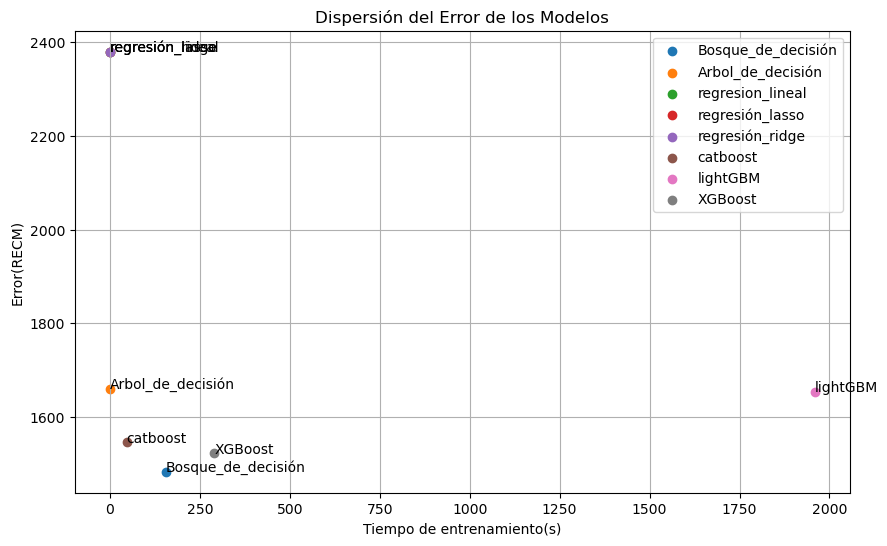

In [71]:
plt.figure(figsize=(10, 6))
for modelo in df_modelos['Modelo']:
    subset = df_modelos[df_modelos['Modelo'] == modelo]
    plt.scatter(subset['Tiempo de entrenamiento'], subset['Error'], label=modelo)
    for i in range(subset.shape[0]):
        plt.text(subset['Tiempo de entrenamiento'].iloc[i], subset['Error'].iloc[i], str(subset['Modelo'].iloc[i]))
plt.title('Dispersión del Error de los Modelos')
plt.xlabel('Tiempo de entrenamiento(s)')
plt.ylabel('Error(RECM)')
plt.grid(True)
plt.legend()
plt.show()


De nuestro grafico podemos notar multiples cosas:
- Todos los modelos tienen un error menor a la regresión lineal, lo cual sirve como **prueba de cordura** para todos los modelos.
- Todos los modelos tienen un tiempo mucho menor al árbol de decisión tradicional

Esto nos deja con cuatro posibles candidatos para mejor modelo:
- Árbol tradicional
- Catboost
- XGBoost
- LightGBM

Haciendo un grafico de dispersión para estos cuatro:


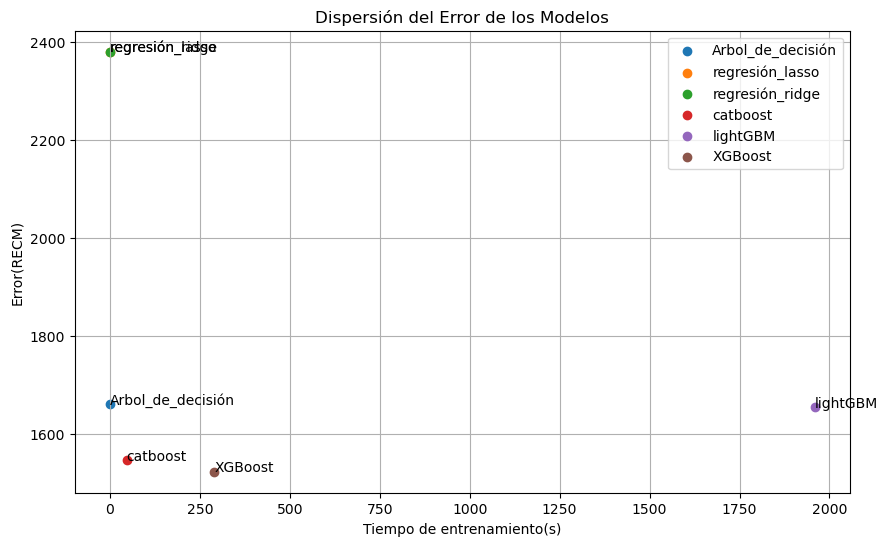

In [72]:
df_modelos.drop([2,0],axis=0,inplace=True)
plt.figure(figsize=(10, 6))
for modelo in df_modelos['Modelo']:
    subset = df_modelos[df_modelos['Modelo'] == modelo]
    plt.scatter(subset['Tiempo de entrenamiento'], subset['Error'], label=modelo)
    for i in range(subset.shape[0]):
        plt.text(subset['Tiempo de entrenamiento'].iloc[i], subset['Error'].iloc[i], str(subset['Modelo'].iloc[i]))
plt.title('Dispersión del Error de los Modelos')
plt.xlabel('Tiempo de entrenamiento(s)')
plt.ylabel('Error(RECM)')
plt.grid(True)
plt.legend()
plt.show()

Dependiendo de la importancia del tiempo de entrenamiento y precisión, podemos decidir si el mejor modelo es XGBoost o un árbol tradicional, de primera instancia proponemos a **XGBoost como mejor modelo** por su buena relación entre tiempo de entrenamiento y error; esto devido a que:
- Catboost  tiene un tiempo entrenamiento alrededor de mas 1.6 veces mas grande.
- LightGBM tiene un tiempo de entrenamiento alrededor de 2.1 veces mas grande.
- El árbol de decisión tradicional tiene un error alrededor de 1.2 mayor
- XGBoost tiene un tiempo de entrenamiento alrededor de 6 veces mayor al de un arbol tradicional.

Proponemos que el mejor modelo es generado con "*XGBoost*" con un error de:

$RECM=1290.385$

y un tiempo de entrenamiento de:

$XGBoost_{time}=24.82s$

y los siguientes hiperparametros: 

$n_{estimators}= 50$

$best_{depth}= 10$

# Conclusiones:



De este proyecto podemos señalar lo siguiente:
- Siempre se debe revisar el estado de los datos de entrenamiento; pues si entra basura, saldrán predicciones basura.
    - Se corrigieron multiples registros numericos nulos en la mayoria de las columnas numericas sin alterar significativamente su estadistica, a traves del uso de la mediana, desechar datos irreales y un modelo lineal.
    - En las columnas categoricas, se etiquetó correctamente los registos nulos.
    - se escalaron correctamente los datos
    - se codificaron los datos con OHE para los modelos que lo requieren.
- Se entrenaron seis modelos iterando a través de sus hiperparametros.
    - Encontramos los mejores candidatos en un espacio de hiperparametros.
    - Hicimos nuestra propuesta de mejor modelo basandonos en las metricas de "RECM" y "tiempo de entrenamiento"
- Observamos de los modelos:
    - La regresión lineal es deficiente en el ajuste de multiples hiperparametros.
    - El árbol de regresión tiene un entrenamiento rapido, pero su error no es optimo.
    - A pesar de entrenar multiples arboles, el bosque aleatorio de regresión tiene un error de calidad media, sin embargo el tiempo que toma en ser entrenado es demasiado.
    - Los algoritmos de descenso del gradiente otorgan errores optimos para esta tarea, son robustos y requieren menos pre-procesamiento de datos.
- Hace falta optimizar los modelos usando GridSearchCV, evitando los bucles *for* y aplicando *validación cruzada*
    
**Considerando las necesidades de  *Rusty Bargain*, proponemos el uso de *XGBoost* para las predicciones de su aplicación, debido a su excelente balance de calidad de predicción y tiempo de entrenamiento.**

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a> Las conclusiones están bien fundamentadas, y la recomendación de XGBoost como el mejor modelo es lógica considerando los resultados obtenidos. Has logrado proporcionar una evaluación clara de los diferentes modelos y explicar de manera concisa por qué XGBoost es la mejor opción para Rusty Bargain. </div> <div class="alert alert-block alert-warning"> <b>Comentario del revisor</b> <a class="tocSkip"></a> Una sugerencia para mejorar sería incluir un análisis sobre la escalabilidad de estos modelos. Por ejemplo, ¿cómo cambiaría el rendimiento del modelo si se agregaran más datos? Además, podrías considerar la implementación de GridSearchCV para optimizar los hiperparámetros de los modelos de manera más eficiente. </div>







# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x ]  El código no tiene errores
- [x ]  Las celdas con el código han sido colocadas en orden de ejecución
- [x ]  Los datos han sido descargados y preparados
- [x ]  Los modelos han sido entrenados
- [x ]  Se realizó el análisis de velocidad y calidad de los modelos